In [2]:
import os
from fastai.vision.all import *
import numpy as np
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
path = Path("D:/datasets/birds/images_complete/birds_train")
dest = "D:/datasets/birds/images_complete/birds_train/Common_Raven/1.jpg"

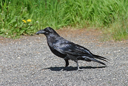

In [4]:
im = Image.open(dest) #test the directory
im.to_thumb(128,128)

In [5]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

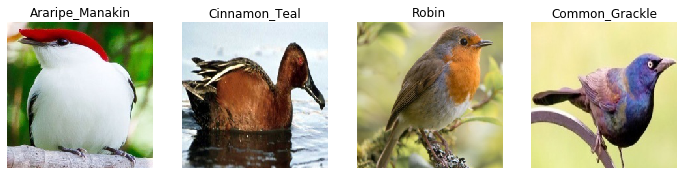

In [6]:
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

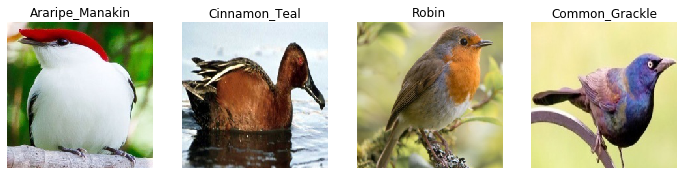

In [7]:
# data augmentation
birds = birds.new(item_tfms=Resize(224, ResizeMethod.Squish))
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

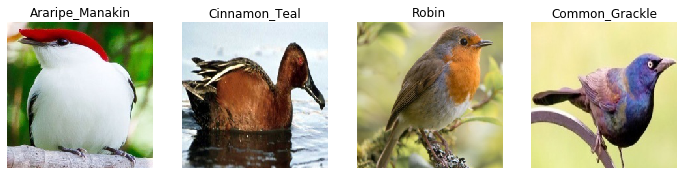

In [8]:
birds = birds.new(item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'))
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

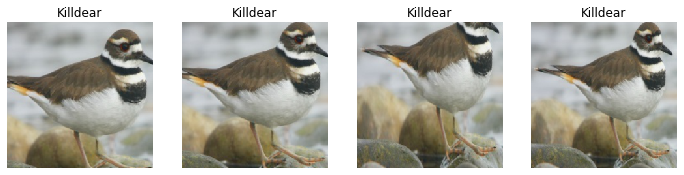

In [9]:
birds = birds.new(item_tfms=RandomResizedCrop(224, min_scale=0.3))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

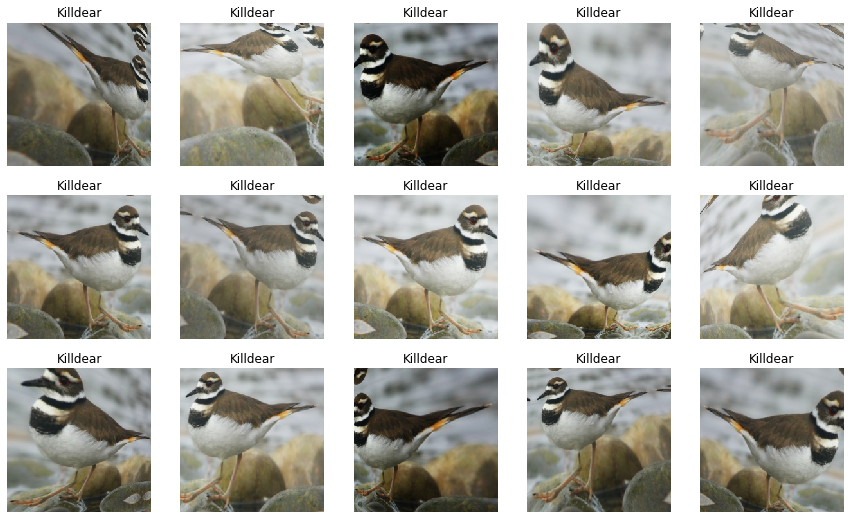

In [10]:
birds = birds.new(item_tfms = Resize(224), batch_tfms = aug_transforms(mult = 2))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n = 15, nrows = 3, unique = True)

In [11]:
# final data block
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = birds.dataloaders(path, num_workers = 0)

In [15]:
gc.collect()
torch.cuda.empty_cache()
learn = cnn_learner(dls,resnet50, metrics = error_rate).to_fp16()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.010964781977236271)

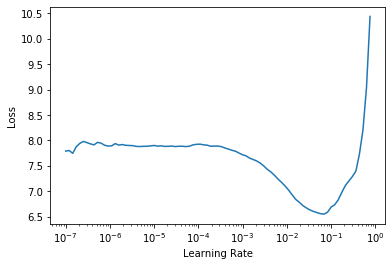

In [16]:
learn.lr_find()

In [17]:
learn.fine_tune(7,lr = 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.858982,0.992577,0.244472,05:25


epoch,train_loss,valid_loss,error_rate,time
0,0.927378,0.593996,0.154081,04:35
1,0.859216,0.566968,0.151439,04:36
2,0.611924,0.424071,0.114170,04:36
3,0.461605,0.378111,0.105827,04:34
4,0.294120,0.316020,0.087192,04:48
5,0.184060,0.281631,0.075789,04:38
6,0.131466,0.275705,0.071756,04:37


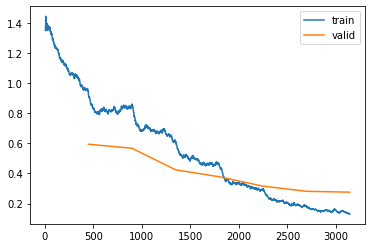

In [18]:
learn.recorder.plot_loss()

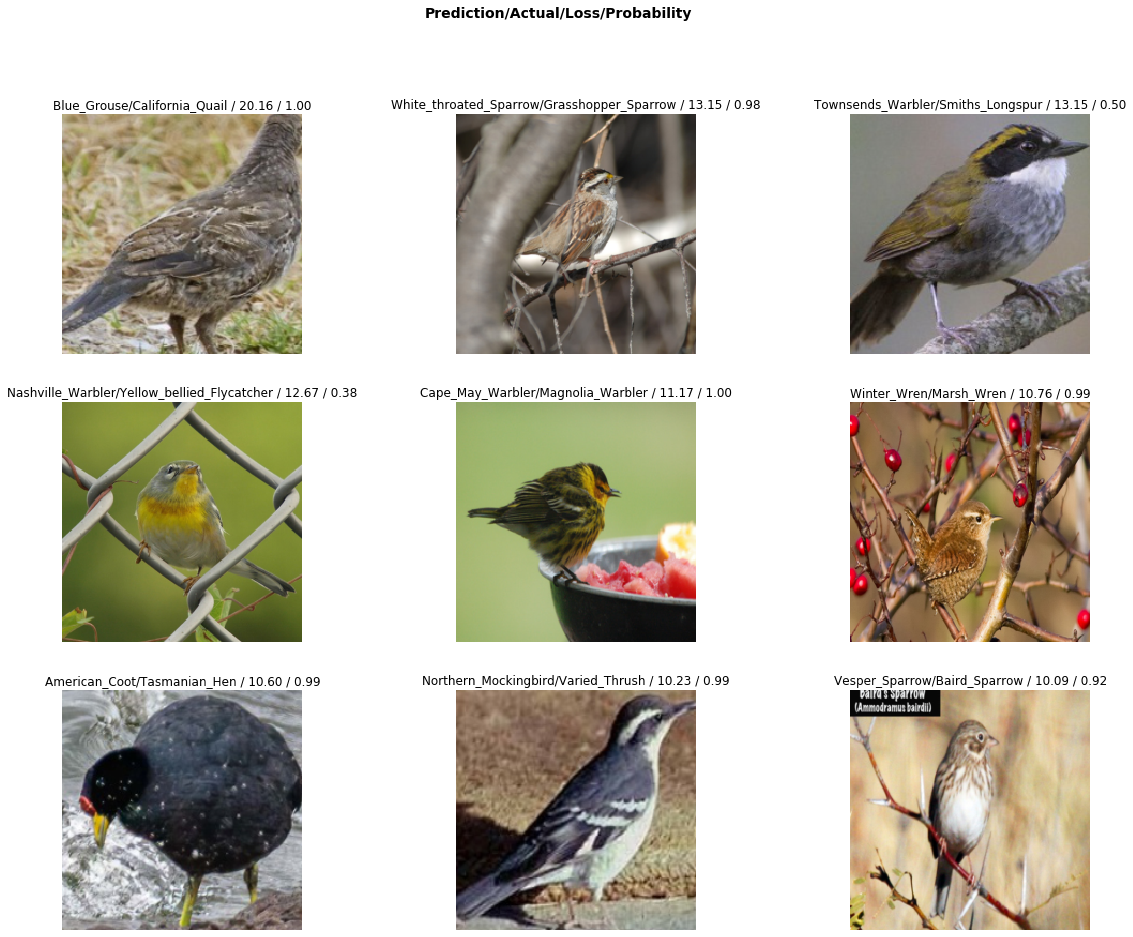

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, nrows=3, figsize = (20,15))

In [20]:
learn.export("first_resnet50_7ep_071.pkl")

In [21]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.290429,0.392588,0.099569,10:40


epoch,train_loss,valid_loss,error_rate,time
0,0.294188,0.403098,0.102211,04:40
1,0.371978,0.415720,0.105688,04:45
2,0.261335,0.341476,0.086914,04:45
3,0.153163,0.299073,0.077319,04:41
4,0.089215,0.280200,0.071756,04:40


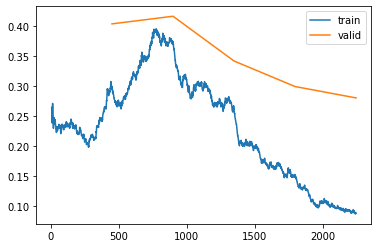

In [22]:
learn.recorder.plot_loss()

In [23]:
learn.export("first_resnet50_7+5ep_071.pkl")

# Trying to train without pretraining, empty resnet 50


In [24]:
gc.collect()
torch.cuda.empty_cache()
learn = cnn_learner(dls,resnet50,pretrained=False, metrics = error_rate).to_fp16()

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=7.585775847473997e-07)

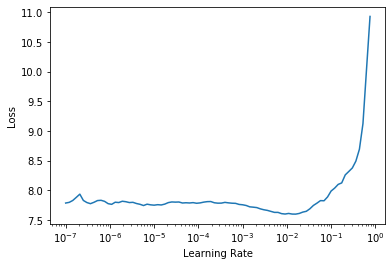

In [25]:
learn.lr_find()

In [26]:
learn.fit(7)

epoch,train_loss,valid_loss,error_rate,time
0,5.368488,5.608479,0.907384,04:55
1,4.801154,3.927850,0.790433,05:02
2,4.029092,5.519712,0.735781,06:03
3,3.472382,3.033629,0.615492,05:18
4,3.099374,2.652244,0.536226,04:43
5,2.865293,3.407195,0.512307,04:41
6,2.685800,3.359386,0.492421,04:39


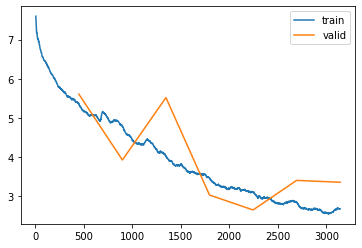

In [27]:
learn.recorder.plot_loss()

This does not look very promising.


Let's see how well the first one does on the test set.

In [29]:
learn_inf = load_learner("C:/Users/ms101/OneDrive/DataScience_ML/projects/birds_classifier/first_resnet50_7ep_071.pkl")

In [31]:
base_dir = "D:/datasets/birds/archive (2)/test"
test_species = []
for fn in os.listdir(base_dir):
    test_species.append(fn)
assert(len(test_species) == 225) #check if all folders ended up in the list

In [32]:
#loop through all
picture_names = ["/1.jpg","/2.jpg","/3.jpg","/4.jpg","/5.jpg"]
predictions = []
for species in test_species:
    for picture in picture_names:
        preds = learn_inf.predict(base_dir + "/" + species + picture)[0];
        predictions.append(preds);
assert(len(predictions) == 225 * 5)
print(len(predictions))

1125


In [33]:
test_species_5 = np.repeat(test_species,5)
print(len(test_species_5))


1125


In [34]:
assert(len(test_species_5) == len(predictions))
correct = []
for label,pred in zip(test_species_5,predictions):
    if label == pred:
        correct.append(1)
    else:
        correct.append(0)
correct = np.array(correct)

In [35]:
true_predictions = len(correct[np.where(correct == 1)])
false_predictions = len(correct[np.where(correct == 0)])

In [36]:
print("Correct Predictions:", true_predictions)
print("False Predictions:", false_predictions)
print("Accuracy:", true_predictions/1125)

Correct Predictions: 1010
False Predictions: 115
Accuracy: 0.8977777777777778
